# Morris Lecar simplified neuron model

In [183]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits import mplot3d
from __future__ import division
from scipy.integrate import odeint
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from numpy.linalg import norm

%matplotlib inline

In [184]:
# Morris Lecar parameters near SNLC
phi = 0.067
g_Ca = 4
V3 = 12
V4 = 17.4
E_Ca = 120
E_K = -84
E_L = -60
g_K = 8
g_L = 2
V1 = -1.2
V2 = 18
C_M = 20

# ionic gates
def m_inf(V): return 0.5*(1.+np.tanh((V-V1)/V2))
def tau_n(V): return 1./np.cosh((V-V3)/(2*V4))
def n_inf(V): return 0.5*(1.+np.tanh((V-V3)/V4))
    
# ionic currents
def I_leak(V): return g_L*(V-E_L)
def I_K(V,n): return g_K*n*(V-E_K)
def I_Ca(V): return g_Ca*m_inf(V)*(V-E_Ca)

# neuron dynamics
def MLneuronVF(X,t,I_ext=0):
    V,n = X
    dV = (I_ext-I_leak(V)-I_K(V,n)-I_Ca(V))/C_M
    dn = phi*(n_inf(V)-n)/tau_n(V)
    return dV,dn

## Ionic variables

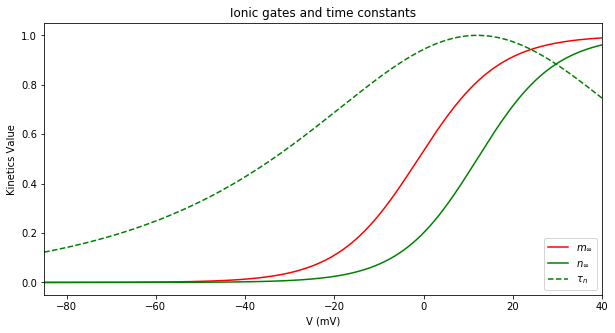

In [185]:
# plot ionic gate kinetics
Vsweep = sp.linspace(-85.0, 40.0, 500)

plt.figure(figsize=(10,5));
plt.plot(Vsweep, m_inf(Vsweep), 'r-', label='$m_\\infty$');
plt.plot(Vsweep, n_inf(Vsweep), 'g-', label='$n_\\infty$');
plt.plot(Vsweep, tau_n(Vsweep), 'g--', label='$\\tau_n$');
plt.xlabel('V (mV)');
plt.ylabel('Kinetics Value');
plt.xlim(Vsweep[0], Vsweep[len(Vsweep)-1]);
plt.legend(loc='lower right');
plt.title('Ionic gates and time constants');

## Neural dynamics

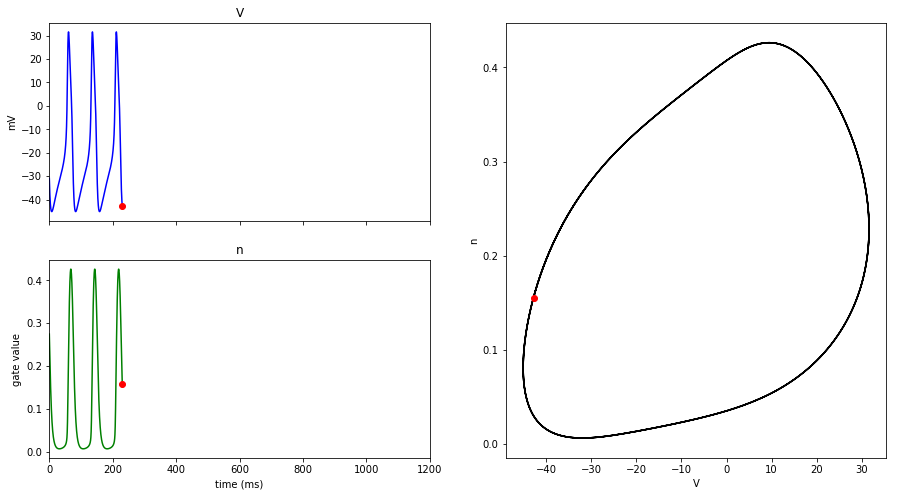

In [4]:
# integration parameters
t_span = np.arange(0.0, 400.0, 0.1) 
I_ext = 60 # external current
X0 = [-0, 0.25] # initial condition[V0,n0]

# call ode solver
X = odeint(lambda X,t: MLneuronVF(X,t,I_ext=I_ext), X0, t_span)

def slider_plot(slider):
    slider = int(slider)
    # plot
    plt.figure(figsize=(15,8));
    # Voltage
    axV = plt.subplot(2,2,1);
    axV.plot(t_span[:slider],X[:slider,0],'b');
    axV.plot(t_span[slider-1],X[slider-1,0],'ro');
    axV.set_title('V');
    axV.set_ylabel('mV');
    plt.xlim([0,t_span[-1]]);
    plt.setp(axV.get_xticklabels(), visible=False);

    # n
    axn = plt.subplot(2,2,3,sharex=axV);
    axn.plot(t_span[:slider],X[:slider,1],'g');
    axn.plot(t_span[slider-1],X[slider-1,1],'ro');
    axn.set_title('n');
    axn.set_ylabel('gate value');
    axn.set_xlabel('time (ms)');
    plt.xlim([0,t_span[-1]]);

    # V,n orbit
    axP = plt.subplot(2,2,(2,4));
    axP.plot(X[:slider,0],X[:slider,1],'k');
    axP.plot(X[slider,0],X[slider,1],'ro');
    axP.set_xlabel('V');
    axP.set_ylabel('n');
    
interact(slider_plot, slider = widgets.FloatSlider(value=0,
                                               min=1,
                                               max=len(t_span)-1,
                                               step=100));

## Two sols, different I_ext

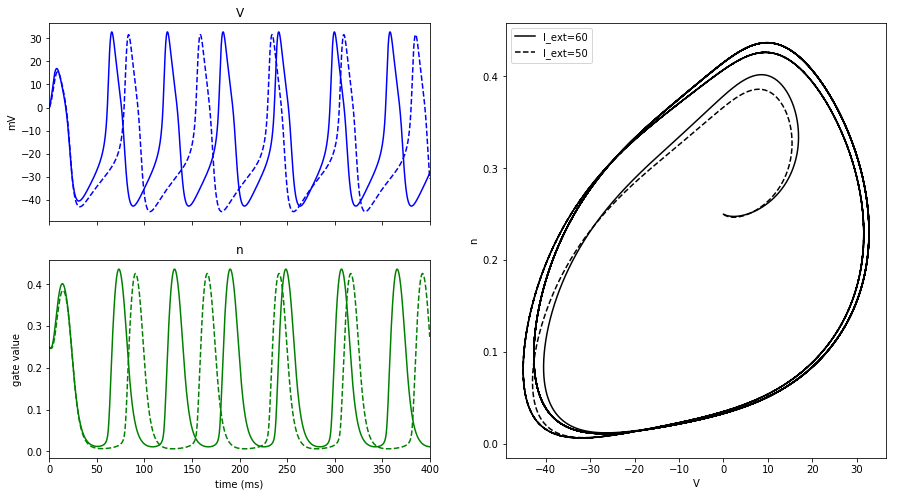

In [5]:
# integration parameters
t_span = np.arange(0.0, 400.0, 0.1) 
X0 = [-0, 0.25] # initial condition[V0,n0]
I_ext1 = 60
I_ext2 = 50

# call ode solver
X1 = odeint(lambda X,t: MLneuronVF(X,t,I_ext=I_ext1), X0, t_span)
X2 = odeint(lambda X,t: MLneuronVF(X,t,I_ext=I_ext2), X0, t_span)

# plot
plt.figure(figsize=(15,8));
# Voltage
axV = plt.subplot(2,2,1);
axV.plot(t_span,X1[:,0],'b');
axV.plot(t_span,X2[:,0],'b--');
axV.set_title('V');
axV.set_ylabel('mV');
plt.xlim([0,t_span[-1]]);
plt.setp(axV.get_xticklabels(), visible=False);

# n
axn = plt.subplot(2,2,3,sharex=axV);
axn.plot(t_span,X1[:,1],'g');
axn.plot(t_span,X2[:,1],'g--');
axn.set_title('n');
axn.set_ylabel('gate value');
axn.set_xlabel('time (ms)');
plt.xlim([0,t_span[-1]]);

# V,n orbit
axP = plt.subplot(2,2,(2,4));
axP.plot(X1[:,0],X1[:,1],'k');
axP.plot(X2[:,0],X2[:,1],'k--');
axP.set_xlabel('V');
axP.set_ylabel('n');
axP.legend(['I_ext=%.0f' %I_ext1,'I_ext=%.0f' %I_ext2]);


## Kick perturbation

In [6]:
# define new functions for perturbed dynamics

# step-kick input
def I_kick(t,t1,t2,A):
    if isinstance(t,float):
        tt = np.zeros(1)
    else:
        tt = np.zeros(len(t))
        
    return np.where((t>=t1)&(t<t2),A,tt)
    
    
#     if (t>=t1) and (t<t2):
#         return A
#     else:
#         return 0
    
# neuron dynamics with kick
def MLneuronVF_kick(X,t,I_kick,I_ext=0):
    V,n = X
    dV = (I_kick(t)+I_ext-I_leak(V)-I_K(V,n)-I_Ca(V))/C_M
    dn = phi*(n_inf(V)-n)/tau_n(V)
    return dV,dn



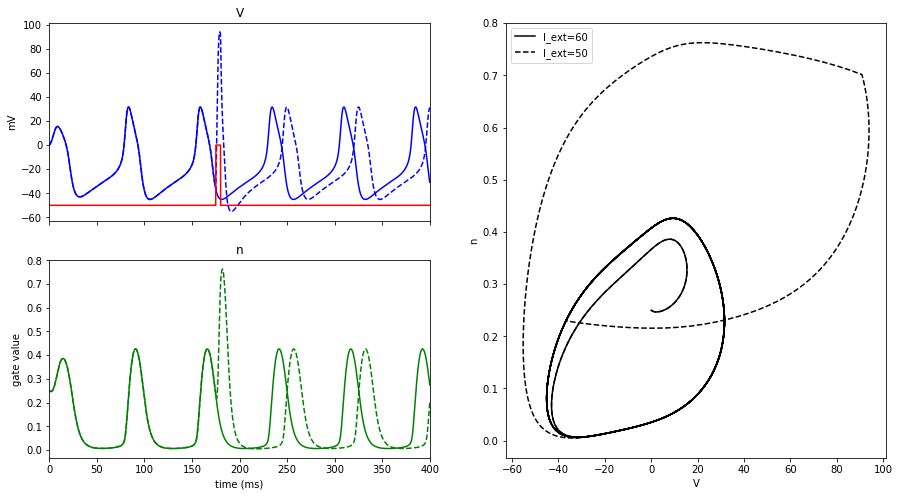

In [86]:
# integration parameters
t_span = np.arange(0.0, 400.0, 0.1) 
I_ext = 50 # external current
X0 = [-0, 0.25] # initial condition[V0,n0]
I_in = lambda t: I_kick(t,t1=175,t2=180,A=1000)

# call ode solver
X1 = odeint(lambda X,t: MLneuronVF(X,t,I_ext=I_ext), X0, t_span)
X2 = odeint(lambda X,t: MLneuronVF_kick(X,t,I_kick=I_in ,I_ext=I_ext), X0, t_span)

# plot
plt.figure(figsize=(15,8));
# Voltage
axV = plt.subplot(2,2,1);
axV.plot(t_span,X1[:,0],'b');
axV.plot(t_span,X2[:,0],'b--');
axV.plot(t_span,I_in(t_span)/20-50,'r')
axV.set_title('V');
axV.set_ylabel('mV');
plt.xlim([0,t_span[-1]]);
plt.setp(axV.get_xticklabels(), visible=False);

# n
axn = plt.subplot(2,2,3,sharex=axV);
axn.plot(t_span,X1[:,1],'g');
axn.plot(t_span,X2[:,1],'g--');
axn.set_title('n');
axn.set_ylabel('gate value');
axn.set_xlabel('time (ms)');
plt.xlim([0,t_span[-1]]);

# V,n orbit
axP = plt.subplot(2,2,(2,4));
axP.plot(X1[:,0],X1[:,1],'k');
axP.plot(X2[:,0],X2[:,1],'k--');
axP.set_xlabel('V');
axP.set_ylabel('n');
axP.legend(['I_ext=%.0f' %I_ext1,'I_ext=%.0f' %I_ext2]);

## Numerically compute PRC

### Find closed orbit and period

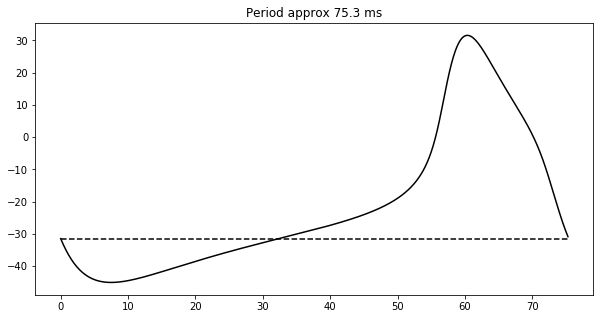

In [8]:
# integration parameters
t_span = np.arange(0.0, 400.0, 0.1) 
I_ext = 50 # external current
X0 = [-0, 0.25] # initial condition[V0,n0]

# call ode solver
X = odeint(lambda X,t: MLneuronVF(X,t,I_ext=I_ext), X0, t_span)

# find period and parametrize
tol = 1e-1;
t = len(t_span)-1
while norm(X[-1,:]-X[t-1,:])>tol:
    t -= 1
T = t_span[-1]-t_span[t] # period
Gamma = X[t:,:] # orbit
phase_span = t_span[t:]-t_span[t] # phase

# plot
plt.figure(figsize=[10,5])
plt.plot(phase_span,Gamma[:,0],'k');
plt.plot(phase_span[[0,len(phase_span)-1]],[X[t,0],X[t,0]],'k--');
plt.title('Period approx %.1f ms' %T);

### Compute PRC by driving finite-size perturbations

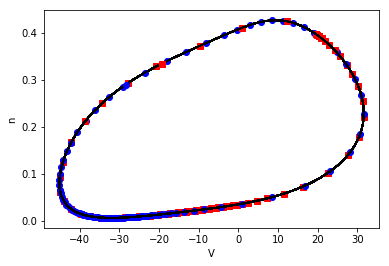

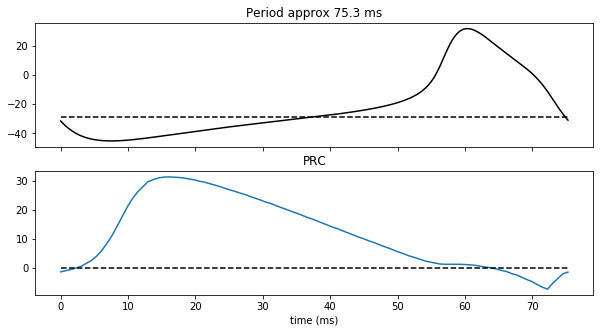

In [89]:
# params
A = 20. # perturbation amplitude
perturbation = np.array([A,0]) # in 2D phase space
t_span = np.arange(0.0, 3*T, 0.1)
T_len = int(T/(t_span[1]-t_span[0]))
tol = 0.3;

# compute phase diff following perturbation for range of phases in [0,T)
PRC = []
plt.figure();
for X0 in Gamma[np.linspace(0,len(Gamma)-1,100,dtype=int)]:
    X = odeint(lambda X,t: MLneuronVF(X,t,I_ext=I_ext), X0, t_span)
    Xk = odeint(lambda X,t: MLneuronVF(X,t,I_ext=I_ext), X0+perturbation, t_span)
    D = [norm(a-Xk[-1,:]) for a in X[len(t_span)-T_len:,:]]
    ind = np.where(D==min(D))[0][-1]
    delta = T-phase_span[ind]
    if delta<T/2:
        PRC.append(-delta)
    else:
        PRC.append(T-delta)
    
    axP = plt.subplot(111)
    axP.plot(X[:,0],X[:,1],'k');
    axP.plot(X[-1,0],X[-1,1],'bo');
    axP.plot(Xk[-1,0],Xk[-1,1],'rs');
    axP.set_xlabel('V');
    axP.set_ylabel('n');
    
# smooth PRC from numerical instabilities
Ptol = 1.
for i in range(len(PRC)):
    if (abs(PRC[i%len(PRC)]-PRC[(i-1)%len(PRC)])>Ptol) & (abs(PRC[i%len(PRC)]-PRC[(i+1)%len(PRC)])>Ptol):
        PRC[i%len(PRC)] = 0.5*(PRC[(i-1)%len(PRC)]+PRC[(i+1)%len(PRC)])

# plots
plt.figure(figsize=[10,5]);
# orbit and all phases perturbed
ax1 = plt.subplot(2,1,1);
ax1.plot(phase_span,Gamma[:,0],'k');
ax1.plot([0,T],[X[-1,0],X[-1,0]],'k--');
ax1.set_title('Period approx %.1f ms' %T);
plt.setp(ax1.get_xticklabels(), visible=False);
# PRC
ax2 = plt.subplot(2,1,2,sharex=ax1);
ax2.plot(np.linspace(0,T,len(PRC)),PRC);
ax2.plot([0,T],[0,0],'k--')
ax2.set_xlabel('time (ms)');
ax2.set_title('PRC');



# Iterative system using the PRC

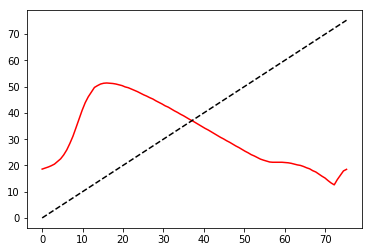

In [90]:
# create PRC function from interpolation

from scipy.interpolate import interp1d

PRC_time = np.linspace(0,T,len(PRC))
PRC = np.array(PRC)
tau = 20.

def F(x,tau=0.):
    f = interp1d(PRC_time,PRC)
    return (f(x)+tau)%T

plt.figure();
plt.plot(PRC_time,F(PRC_time,tau),'r')
plt.plot([0,T],[0,T],'k--');

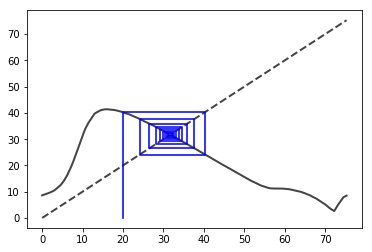

In [91]:
# cobwed plot of translated PRC
tau = 10.
f = lambda x : F(x,tau=tau)
nmax = 40 # num iterates
x0 = 20.

x = np.linspace(0, T, 500)
fig = plt.figure();
ax = fig.add_subplot(111);

# Plot y = f(x) and y = x
ax.plot(x, f(x), c='#444444', lw=2);
ax.plot(x, x,'--', c='#444444', lw=2);

# Iterate x = f(x) for nmax steps, starting at (x0, 0).
px, py = np.empty((2,nmax+1,2))
px[0], py[0] = x0, 0
for n in range(1, nmax, 2):
    px[n] = px[n-1]
    py[n] = f(px[n-1])
    px[n+1] = py[n]
    py[n+1] = py[n]

# Plot the path traced out by the iteration.
ax.plot(px, py, c='b', alpha=0.7);

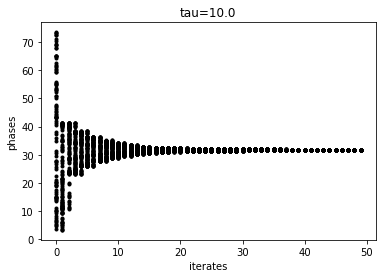

In [129]:
# iteration of many initial conditions
num_IC = 100
num_iterates = 50
X0 = np.random.uniform(0,T,size=num_IC)
tau=10.

plt.figure();
X = X0
for i in range(num_iterates):
    plt.plot(i*np.ones(X.shape),X,'k.');
    X = F(X,tau)
plt.xlabel('iterates');
plt.ylabel('phases');
plt.title('tau=%.1f' %tau);


## Simulated population of neurons with common kicks (synchrony)

In [176]:
# periodic step-kick input
def P_kick(t,tau,T,A,delta,tmin=0,tmax=float("inf")):
    if isinstance(t,float):
        tt = np.zeros(1)
    else:
        tt = np.zeros(len(t))
        
    return np.where((t%(T+tau)>=0)&(t%(T+tau)<delta)&(t>tmin)&(t<tmax),A,tt)

<IPython.core.display.Javascript object>


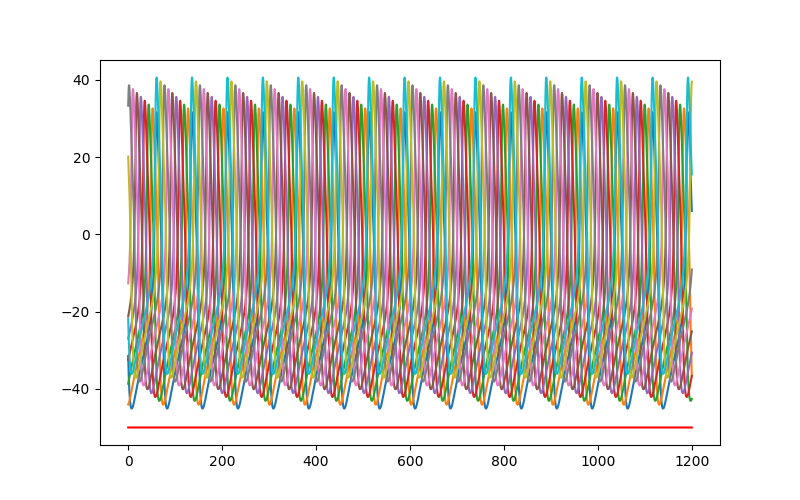

In [182]:
# simulate ensemble of neurons with different phases receiving periodic kick

# integration parameters
num_IC = 10
t_span = np.arange(0.0, 1200.0, 0.1) 
I_ext = 50 # external current
X0 = [Gamma[int(i)] for i in np.linspace(0,len(Gamma)-1,num_IC)] # initial condition[V0,n0]

# kick signal
tau = 10.
A = 0. #500.
I_in = lambda t: P_kick(t,tau=20.,T=T,A=A,delta=2,tmin=500,tmax=1000)

%matplotlib notebook
plt.figure(figsize=(8,5));
for ic in range(num_IC):
    # call ode solver
#     X = odeint(lambda X,t: MLneuronVF(X,t,I_ext=I_ext), X0[ic], t_span)
    X = odeint(lambda X,t: MLneuronVF_kick(X,t,I_kick=I_in ,I_ext=I_ext), X0[ic], t_span)
    plt.plot(t_span,X[:,0]+ic)
plt.plot(t_span,I_in(t_span)/20-50,'r')